## *Only modify "system specific modifications" and "find genes to mark specific region" box*

- Download attached files and point via system specific modifications to: CCF_borders_10um.tif, top_view_paths_10.h5, gridAnnotation.mhd via "system specific modifications" cell

- Preallocate a folder for storing gene expression top view images, designated as searchpath
 - MAKE FOLDER PRIOR TO RUNNING CELL

In [3]:
import os
import numpy as np
import nrrd
import scipy.ndimage
from scipy.stats import mannwhitneyu as mw
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import tifffile as tiff 
from glob import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import pandas as pd
import h5py
import SimpleITK as sitk 
import urllib
import json
from IPython.html.widgets import interact
from math import log10
import zipfile

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(manifest_file='connectivity/manifest.json', resolution=10)
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.structure_tree import StructureTree
from allensdk.core.reference_space import ReferenceSpace
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
from allensdk.config.manifest import Manifest

#### System specific modifications

In [4]:
# File Locations
## CCF_borders_10um.tif LOCATION: 
cortextif_path = r"\\allen\programs\braintv\workgroups\nc-ophys\Jack\Natalie_Weed\Natalie\files\CCF_borders_10um.tif"

## top_view_paths_10.h5 LOCATION:
view_file = r"\\allen\programs\braintv\workgroups\nc-ophys\Jack\Natalie_Weed\Natalie\files\top_view_paths_10.h5"

## gridAnnotation.mhd LOCATION:
annot_200_img = sitk.ReadImage(r"\\allen\programs\braintv\workgroups\nc-ophys\Jack\Natalie_Weed\Natalie\files\gridAnnotation.mhd")

# Where images will be saved to
## Make a folder for gene maps to be directed to prior to running this cell
searchpath = r'E:/genemaps/coronal/'


RuntimeError: Exception thrown in SimpleITK ReadImage: /Users/runner/runners/2.160.0/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "\\allen\programs\braintv\workgroups\nc-ophys\Jack\Natalie_Weed\Natalie\files\gridAnnotation.mhd" does not exist.

# Code Explanation, part 1

Mapping of gene expression data from the mouse brain atlas coronal data to common coordinate frame using projections along paths to edge of cortex, and subsequent projection to a horizontal plane as viewed from the top of the brain. This code will pull data from the Allen server and create tif images of each experiment, storing the images in the path that the notebook is stored in. If images are already generated (with proper nomenclature), they will not be recreated. Images are named as "genename_experimentnumber.tif". No external variables are inputted. No variables are explicitly returned. Images are saved to searchpath. Names of mice are printed. Dash is printed after name of mouse if top view image already exists in folder.

Once images are generated, the specific mice identification can also be printed out using the view_mouse function.

In [3]:
def get_paths_lut(view_file):
    # open view index file
    vi = h5py.File(view_file, 'r')
    
    # initialize
    lut = vi['view lookup'][:]
    paths = vi['paths'][:]
    vi.close()
    return {'lut': lut, 'paths': paths}

def create_top_view_projection(image, top_view):
    # initialize
    output = np.zeros(top_view['lut'].shape + (2,), image.dtype)
    output[:,:,1] = 0
    dims_10 = (1320, 800, 1140)
    dims_200 = (67, 41, 58)

    def max_along_path(pid):
        path = top_view['paths'][pid,:]
        path_200 = np.array(np.unravel_index(path, dims_10))
        path_20 = np.ravel_multi_index((path_200 / 20).astype(int), dims_200)
        arr = image.flat[path_20]
        idmax = np.argmax(arr)
        vmax = arr[idmax]
        indmax = path[idmax]

        return vmax, indmax

    ind = np.where(top_view['lut'] > -1)
    output[ind] = map(max_along_path, top_view['lut'][ind])

    return output[:,:,0], output[:,:,1].astype(np.int32)

def get_section_image(section_id):
    grid_download_template = "http://api.brain-map.org/grid_data/download/{:s}?include=density"

    grid_download_url = grid_download_template.format(str(section_id))
    urllib.urlretrieve(grid_download_url, "griddata.zip")

    with zipfile.ZipFile("griddata.zip", "r") as zip_ref:
        zip_ref.extractall("griddata")

    img = sitk.ReadImage("griddata/density.mhd")
    arr = sitk.GetArrayFromImage(img)
    arr = np.swapaxes(arr, 0, 2)
    return arr

def apply_mask(griddata, mask):
    griddata[mask == 0] = -1
    return griddata

def create_map(section_id, gene_name, mask, top_view):
    filename = os.path.normpath(searchpath + gene_name + "_" + str(section_id) + ".tif")
    if os.path.isfile(filename):
        print "_"
    else:
        data = get_section_image(section_id)
        data = apply_mask(data, mask) # to apply isocortex mask
        output, depth = create_top_view_projection(data, top_view)
        output = output.astype(float)
        tiff.imsave(filename, output)
        
def images_main():
    
    rma_url = ("http://api.brain-map.org/api/v2/data/query.json?criteria=" +
               "model::SectionDataSet,rma::criteria,[failed$eqFalse]," +
               "plane_of_section[name$eqcoronal],products[name$eq'Mouse%20Brain']," +
               "treatments[name$eqISH],rma::include,genes," +
               "rma::options[only$eq'genes.acronym,id'][num_rows$eqall]")
    
    response = urllib2.urlopen(rma_url).read()
    data = json.loads(response)
    sections = {v["id"]: v["genes"][0]["acronym"] for v in data["msg"]}

    for section_id in sections:
        print sections[section_id].replace('*', '_')
        create_map(section_id, sections[section_id].replace('*', '_'), isocortex_200_mask, top_view)
        
def create_top_view_projection_masks(image, top_view):
    # initialize
    output = np.zeros(top_view['lut'].shape + (2,), image.dtype)
    output[:,:,1] = 0
    dims_10 = (1320, 800, 1140)

    def max_along_path(pid):
        path = top_view['paths'][pid,:]
        path_200 = np.array(np.unravel_index(path, dims_10))
        path_20 = np.ravel_multi_index((path_200 ).astype(int), dims_10)
        arr = image.flat[path_20]
        idmax = np.argmax(arr)
        vmax = arr[idmax]
        indmax = path[idmax]

        return vmax, indmax

    ind = np.where(top_view['lut'] > -1)
    output[ind] = map(max_along_path, top_view['lut'][ind])

    return output[:,:,0], output[:,:,1].astype(np.int32)

def create_map_single(data, top_view, name):
    output, depth = create_top_view_projection_masks(data, top_view)
    output = output.astype(float)
    tiff.imsave(name,output)
        
def image_main_single(index,name):
    filename = os.path.normpath( name) 
    if os.path.isfile(filename):
        print "reference already created"
    else:
        data = rsp.make_structure_mask([index])
        create_map_single(data, top_view, name)
    
def view_mouse():
    
    rma_url = ("http://api.brain-map.org/api/v2/data/query.json?criteria=" +
               "model::SectionDataSet,rma::criteria,[failed$eqFalse]," +
               "plane_of_section[name$eqcoronal],products[name$eq'Mouse%20Brain']," +
               "treatments[name$eqISH],rma::include,genes," +
               "rma::options[only$eq'genes.acronym,id'][num_rows$eqall]")
    response = urllib2.urlopen(rma_url).read()
    data = json.loads(response)
    sections = {v["id"]: v["genes"][0]["acronym"] for v in data["msg"]}
    for section_id in sections:
        print section_id, sections[section_id]

##### Making the reference space, as taken from AllenSDK

In [4]:
# the annotation download writes a file, so we will need somwhere to put it
annotation_dir = 'annotation'
Manifest.safe_mkdir(annotation_dir)

annotation_path = os.path.join(annotation_dir, 'annotation.nrrd')

# this is a string which contains the name of the latest ccf version
annotation_version = MouseConnectivityApi.CCF_VERSION_DEFAULT

mcapi = MouseConnectivityApi()
mcapi.download_annotation_volume(annotation_version, 10, annotation_path)

annotation, meta = nrrd.read(annotation_path)

oapi = OntologiesApi()
structure_graph = oapi.get_structures_with_sets([1])  # 1 is the id of the adult mouse structure graph

# This removes some unused fields returned by the query
structure_graph = StructureTree.clean_structures(structure_graph)  

tree = StructureTree(structure_graph)

# build a reference space from a StructureTree and annotation volume, the third argument is 
# the resolution of the space in microns
rsp = ReferenceSpace(tree, annotation, [10, 10, 10])

2018-10-09 16:30:07,601 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_10.nrrd


## Isocortex mask
Make Isocortex mask in 2 dims and 3 dims

In [8]:
# Global files
top_view = get_paths_lut(view_file)
cortextif = tiff.imread(cortextif_path)

In [5]:
cortex = tree.descendant_ids([315])[0]
annot_200 = sitk.GetArrayFromImage(annot_200_img)
annot_200 = np.swapaxes(annot_200, 0, 2)

isocortex_200_mask = np.zeros_like(annot_200, dtype=np.uint8)
for sid in cortex:
    isocortex_200_mask[annot_200 == sid] = 1

In [6]:
name = 'isocortexmask.tif'
image_main_single(315,name)
isocortexmask_2d = tiff.imread(name)

reference already created


## Generate Gene Expression Images (Horizontal view, top projections)

In [9]:
images_main()

Inpp5a
_
Snap47
_
Nvl
_
Gtf3c2
_
Acadl
_
Baiap3
_
S100a6
_
Clock
_
Mageh1
_
Sncg
_
Hnrnph2
_
Nnat
_
Cdca7
_
Prkag2
_
Uggt1
_
Dopey2
_
Anln
_
Hepacam
_
Setd5
_
Cnih3
_
Thap1
_
TC1541413
_
Htr1a
_
9130024F11Rik
_
Mansc1
_
Pmch
_
Prune2
_
Il1rap
_
Acta1
_
Pcdh9
_
Actc1
_
Actr10
_
Ctla4
_
Rell1
_
Actr2
_
Fut8
_
Il34
_
9130024F11Rik
_
Adcy2
_
Scarb2
_
Adcy3
_
Adcy4
_
Adcy5
_
Adcy6
_
Adcy9
_
Rps19
_
Agpat3
_
Agt
_
Mllt11
_
Akap8
_
Anp32a
_
Mt3
_
Capsl
_
Etnppl
_
Gata2
_
Cdc42ep1
_
Rab6a
_
App
_
Ifi205
_
Spag5
_
Runx2
_
Arf3
_
Arhgap5
_
Hgf
_
Arx
_
Recql5
_
Thbd
_
Cit
_
Tmeff2
_
Atp5j
_
Htr4
_
Atp6v0a1
_
Atp6v1b2
_
Nes
_
Tmem50b
_
Rbp4
_
Stat5b
_
Rbm19
_
Prrt3
_
Cyp26b1
_
Atp6v1e1
_
Fign
_
Bace2
_
Gnao1
_
Slc32a1
_
Stmn1
_
Fstl1
_
Usp48
_
Asb13
_
Kcng4
_
Gpr98
_
Bcan
_
Lhx5
_
Ptcd2
_
Cyhr1
_
Bsg
_
Btg3
_
Gpalpp1
_
Btbd3
_
Nrcam
_
Uqcrc2
_
Calm1
_
Setd7
_
Trh
_
Calm3
_
Mmgt1
_
Ldb3
_
Camk2g
_
Pex14
_
Iqsec1
_
Synj2
_
Ctnnb1
_
Cbx5
_
Gfra1
_
Pfkfb2
_
Oxt
_
Slc6a7
_
Ece2
_
Atp1a3
_
Car7
_
Ccnl2


Pcgf6
_
Spock3
_
Hkdc1
_
Cyp27a1
_
Rcsd1
_
Eef1b2
_
Pcdh1
_
Rnasek
_
Pvrl3
_
Tppp
_
Cish
_
Ap2b1
_
Gm5607
_
3110035E14Rik
_
Med30
_
Hsd11b1
_
Thbs4
_
BC005537
_
Serpina3k
_
Myl4
_
Zbtb20
_
Tmem106b
_
Stk32a
_
Phactr1
_
Itgb5
_
Mybpc1
_
Rftn1
_
Kirrel3
_
Wscd1
_
Sertm1
_
Sertad4
_
Mpp3
_
Sobp
_
Fn1
_
Tanc1
_
Syngr3
_
Dkkl1
_
Fabp5
_
Parva
_
Synpr
_
Ublcp1
_
Gadd45g
_
Gpr125
_
Fam46a
_
Hapln1
_
Llgl1
_
Lgals1
_
Fam50a
_
Ccdc171
_
C1ra
_
S1pr5
_
Fgfr1
_
Depdc7
_
Dtnbp1
_
Aldob
_
Cdca2
_
Gpr137
_
Igsf3
_
Chgb
_
Cd97
_
Fgfr1op2
_
Ube3c
_
Bhlhb9
_
Gprasp1
_
Layn
_
Tmem131
_
Dbp
_
Tex40
_
Ina
_
Uap1
_
Calml3
_
Sc5d
_
Cdh13
_
Gng4
_
Hpcal4
_
Map3k15
_
Map3k15
_
Sparc
_
2010300C02Rik
_
Zfp189
_
Sostdc1
_
Bcar3
_
Flcn
_
Adrb1
_
LOC433228
_
Ubr3
_
Hspb3
_
3830406C13Rik
_
Cnppd1
_
Ndrg2
_
Dbh
_
Nod2
_
Glra3
_
Itga7
_
Kit
_
Apoe
_
Pfkp
_
Nfil3
_
Clu
_
Gpr139
_
Kcnj2
_
Kctd12
_
Cldn5
_
Camk2a
_
Odc1
_
Eid1
_
Prkar2b
_
Ppp1r2
_
Sstr4
_
Elmo1
_
Slc4a2
_
Grik1
_
Crhr2
_
Cxcl12
_
Bend5
_
Dyrk1a
_
Ndufs2

Npr3
_
Pdcd4
_
Rnf19a
_
Acaa2
_
Trim16
_
Flrt2
_
Ptrf
_
LOC235953
_
Robo1
_
Frmpd4
_
LOC380720
_
Slc1a2
_
LOC432928
_
Adamts2
_
Syndig1
_
Gata3
_
4833414E09Rik
_
Tcn2
_
Sigmar1
_
Phf6
_
Uqcrfs1
_
Fhod3
_
Gabra4
_
Inpp4b
_
Garnl3
_
Greb1
_
Gng12
_
Atrx
_
Arhgap27
_
Zfp932
_
Hpd
_
Stxbp2
_
Fam65a
_
Trhde
_
Ubl4
_
Tmem246
_
Ptk2
_
Mtfp1
_
Hspbp1
_
Kcnb2
_
Lgi1
_
Arhgdia
_
Loxl2
_
Lrp4
_
Clip4
_
LOC235580
_
Atpif1
_
Nucb2
_
Mmp16
_
Pomp
_
Nrbp2
_
Rps15
_
Neto1
_
Bcl2l12
_
Ralyl
_
Cntnap3
_
Dpf3
_
Spink8
_
Efcab3
_
Hs6st2
_
Itgb1
_
Nr2f2
_
Asxl3
_
Car9
_
Dicer1
_
Dnah12
_
Gm22
_
Alpk2
_
Sec61a2
_
Nap1l5
_
Ascl5
_
Bad
_
Mrap2
_
LOC270764
_
Ufm1
_
Myo1b
_
Ndnf
_
Plcz1
_
Tshz1
_
Lipa
_
LOC381355
_
LOC545810
_
Lrrn1
_
Tshz2
_
Oxr1
_
Eps15
_
Rtn4r
_
Prdx6b
_
Cdkn1b
_
Ntng1
_
LOC433088
_
Ascl2
_
Vill
_
Sdc2
_
Tmed3
_
Slc7a6
_
Prpsap2
_
C1qtnf5
_
Fndc4
_
Uck1
_
Bap1
_
Serpinb8
_
Rtl1
_
Slc8a3
_
Id4
_
Fgd5
_
Peg10
_
Kctd6
_
Trnp1
_
Btg1
_
Atp6v0b
_
Dexi
_
Pou6f1
_
Rps15a
_
2310003H01Rik
_
Moxd1
_
S

In [10]:
view_mouse()

73994713 Inpp5a
3 Snap47
5 Nvl
7 Gtf3c2
72081416 Acadl
75081206 Baiap3
77278967 S100a6
273 Clock
17 Mageh1
72081426 Sncg
112649906 Hnrnph2
655497 Nnat
26 Cdca7
29 Prkag2
74957909 Uggt1
31 Dopey2
33 Anln
35 Hepacam
37 Setd5
39 Cnih3
44 Thap1
74641209 TC1541413
79556616 Htr1a
51 9130024F11Rik
53 Mansc1
55 Pmch
57 Prune2
1462 Il1rap
60 Acta1
10 Pcdh9
62 Actc1
64 Actr10
75079745 Ctla4
72007746 Rell1
67 Actr2
72007749 Fut8
72007750 Il34
71 9130024F11Rik
73 Adcy2
72081482 Scarb2
75 Adcy3
77 Adcy4
79 Adcy5
81 Adcy6
83 Adcy9
72081492 Rps19
85 Agpat3
87 Agt
89 Mllt11
91 Akap8
94 Anp32a
75079775 Mt3
75079776 Capsl
75079777 Etnppl
100 Gata2
70814345 Cdc42ep1
74047909 Rab6a
106 App
75079787 Ifi205
72081516 Spag5
79556626 Runx2
110 Arf3
113 Arhgap5
77867710 Hgf
118 Arx
75079799 Recql5
75079800 Thbd
75079801 Cit
71015807 Tmeff2
124 Atp5j
72119658 Htr4
126 Atp6v0a1
129 Atp6v1b2
1387 Nes
133 Tmem50b
71016583 Rbp4
71016584 Stat5b
71016585 Rbm19
72081547 Prrt3
72081548 Cyp26b1
655501 Atp6v1e1
72081550 F

70928196 Adk
2249 Galm
70928198 Dbn1
70928199 Cast
1864 Syt13
71717125 Zbtb16
75774681 Hmox2
1868 Tbl2
1870 Tcea3
1872 Tcerg1
1874 Hnf1b
75077262 Hdac7
1878 Fam60a
1880 Pllp
1882 Crlf2
1884 Ubl3
1886 Usp16
1888 Vdac2
77866850 Hspb8
77866852 Tmem176b
1894 Zfp191
74512017 Phldb2
1896 Fcrls
1898 Fam89b
70928238 Car4
1589 Wnt2b
72283795 Ptgfr
1908 Pcdhb17
73512497 Dusp3
1910 Pdgfd
609 Kcnj6
70928248 Igfbp6
70436729 Slc38a3
70928250 Tmc6
70436731 Tspan11
1916 Rxrb
1918 Scnn1g
70436736 Sema3e
70436737 Cap2
1922 Slc4a10
70436739 Fam213a
70436740 Spp1
74819462 Hdac6
74819463 Rsrp1
74819464 Mrpl54
74819465 Efcab6
70436746 Nipal3
70436747 Chrnb3
1932 Mlxipl
70436749 Tmem132a
1934 Wbscr17
70928271 Alcam
1936 Wnt7a
79488913 Cnp
1938 Obfc1
74819475 Lrtm2
74819476 Ap2a2
1944 Tsen34
71717188 Dio3
1946 Micu2
1948 Grina
74819486 Uba6
79488927 Tcf4
71250313 Ccdc184
79488929 Acvrl1
1954 Smg9
79488931 Satb1
70928292 Pea15a
70928293 Rtn1
70928294 Mad1l1
74988529 Ccni
1960 Tmem218
74819497 Dbnl
74881867 Sik

74641314 Rab27b
74641315 Atp6v1a
74641316 Avpr1a
74641317 Aars
74641318 Htr3b
74641319 Pcyt1b
74641320 Ctnnd1
74641321 Cdyl2
74641322 Gpr156
74641323 Ttpal
74641324 Celf3
74641325 Impa1
74641326 Cited1
74819693 Lyz1
356284 Tmem33
356286 Clk2
356287 Phf1
79908802 Limk1
72339397 Dirc2
73520984 Hint1
72340129 Cmklr1
79908808 Mecp2
75041514 Tmc1
74819575 D11Wsu47e
79908817 Notch3
677 Mtif2
79908833 Tenm3
61411 Tnnt3
61413 Gnb1
73992939 Arhgap39
73817426 Zfp804a
79908848 Snca
79556595 Lpar1
67809268 Ogfr
79556597 Rorb
71717115 Tnc
79556601 Efnb3
79556603 Kif5a
79556605 Dkk3
79556607 Pitx2
323585 Map2k5
323586 Rer1
79556611 Galp
323588 Eif2d
323589 Atp5s
79556614 Ddc
2049 Zak
323592 Dynlrb1
323593 Sdccag8
79556618 Cux1
323595 Uqcrb
323597 Dctn6
79556624 Reln
77869074 Cck
79556628 Arhgdig
79556630 Mc4r
321202 Mvp
79556632 Syt12
74047913 Pi4k2a
79556634 Ctgf
79556636 Aldoc
79556638 Pus7
71587845 Thrsp
79556640 Cuedc2
79556642 Gja1
79556644 Cd44
79556646 Lrp5
79591611 Grm2
77869097 Col6a1
79556

73520997 Lin7a
73520998 Nptx1
73520999 Nrip3
73521000 Nxph4
73521001 Pak1
73521002 Pcdh11x
73521003 Pcdh7
73521004 Phactr2
73521005 Plxnd1
71064277 Pogk
1291 Syt12
74274683 Gckr
74274684 Lrmp
74274685 Socs5
74274686 Cdc25b
74274687 Unc5b
72103808 Cds1
72103809 Aldh1a1
72472787 Ddr1
72103819 Diras1
72103820 Igsf11
112646029 Lhx9
80517009 Sh2b3
72103830 Cygb
72103831 Car2
72103841 Col4a6
72103842 Zfp57
72103843 Zic1
79591337 Sema3a
72103854 Nell2
79591351 Tbr1
224 Cd44
73635770 Dpysl5
73635771 Rgs2
73635772 Sccpdh
73635773 Stk24
73635774 Lypd6b
73635775 Kcnq4
73635776 4932418E24Rik
80517057 Hmgcs1
80343383 Cdkn1a
75080694 Tns3
71587782 Pdgfb
74749895 Rapgef4
73635786 Fam69b
71358673 Zfpm2
73635796 Filip1
203 Cckar
75988492 Mapk12
73635806 Fam65b
71587811 Trib2
71587812 Sidt1
79591399 Gpr55
73635816 Pacs2
79591401 Met
79591403 Tmem200a
2137 Clip2
71587822 Cacna1g
73635826 Atp10b
77332684 Lypd6
74749941 Sgcg
74749942 Sgcz
74749943 Slc9a2
74749944 Prss39
71587834 Ano2
71587835 Vwa5b2
748813

74743272 Plk2
77332735 Prkar2a
74743282 Psmd11
74743283 Ptpn4
75144693 P2ry2
1892 Wnt9b
121098 Gabpb1
74882555 Enpp6
74743293 Ptpn5
2645 Stx1a
75988482 Ica1
74882565 F13a1
74743303 Ptprk
72079959 Efnb2
2711 Usp21
73616023 St3gal1
71924259 Kcns2
74882584 Fa2h
112649476 Dvl2
75988508 Slc38a1
74882595 Galnt6
199391 F2rl1
70231303 Mpped1
75988524 Timp2
75988526 Tmod1
75259440 Haghl
75259441 Mrps28
75259443 Fam3c
74882616 Hspb6
75988537 9430020K01Rik
73615803 Ntng2
74882626 Itga11
73512203 Etv1
112647750 Slc35a4
71924321 Ncald
74882636 Itga5
654925 Gabarapl1
654928 Dpysl3
654929 Fam20c
74882646 Kcnj12
75988567 Pak7
75988568 Podn
72007751 Erp29
79912542 Thra
79912544 Dlx6os1
74882657 Mfn2
75988578 Map3k19
79912548 Nrsn2
79912552 Stub1
79912554 Fos
79912556 Chrm3
77332080 Mxra7
72081545 Ticam1
77332082 Ncs1
77332086 Nmbr
77332088 1190002N15Rik
77332090 Nsun7
79908799 Foxb1
77332092 Spsb1
74882685 Hecw1
77332094 Siglech
77332096 Vwc2
77866848 Gucy1a3
75988610 Ddx26b
75988611 LOC434300
77332100

In [11]:
files_list = glob(os.path.join(searchpath, '*.tif'))

# Code Explanation, part 2

Random forest classification of points either inside or outside of the specified cortical area. Cortical areas are taken from the CCF. Then a cortical mask is generated using AllenSDK software and applied through the same gridding and projection process of gene expression data. Then a subset of datapoints is pulled from dilating that cortical mask, which are fed into a random forest. Number of test points total and number of test points inside the cortical area of interest are returned, as well as a visual display of points selected. The random forest is run with 100 decision trees and 100 test points, from which feature relative importance is calculated based on reduction in Gini impurity based on the gene expression pattern. 

Parameters
----------
index : interger
    
    Index of cortical area of interest. Relevant sub areas will also be selected.
   
name : string
    
    Name of cortical area/image to be saved. Convention used was name of cortical area. 

dilation : interger
    
    Number of iterations to dilate the cortical area map by to generate dataset outside 
    of desired region. 
    
    Default is 30 iterations
    
threshold: float

    Threshold of variable importance when generating top importance variables. Variable 
    importances sum to 1.
    
    Default is 0.00 variable importance
    
Returns
-------
'# of classifications of coordinates'
    
    Total number of points pulled from each gene expression .tif image
    
'# of points inside cortical area'
    
    Number of points inside the cortical area of interest
    
'maximum importance'

    Gene with highest variable importance and its variable importance
    
'number of genes'

    Number of genes above threshold of variable importance (default is .005 importance)
    
'Points selected'
    
    Displays coordinates in the CCF. Left image is all points selected, right image is 
    classification of points. Orange region is "inside" cortical region, pink region is 
    "outside" cortical region.
    
'Model accuracy'
    
    Confusion matrix of random forest model on 100 test coordinates. Used to ensure the 
    model is doing a sufficient job of classifying points as inside or outside of 
    cortical region. Also included is the variable importance histogram 
    
Gene Printouts

    Returns gene expression map of top 10 genes in terms of variable importance. Images 
    are underneath gene's file name, as well as variable importance as calculated by the Gini Index.
    


In [12]:
def reference(coordinates, ref_image):
    values = ref_image[coordinates[:,0],coordinates[:,1]]
    print(values.shape[0], '# of classifications of coordinates')
    points_inside = (values/2).astype(int)
    print(sum(points_inside), '# of points inside cortical area')
    return values

def points(image,coordinates): 
    coordinates = coordinates.astype(int)
    size = len(coordinates)
    dataset = np.arange(size)
    x = coordinates[:,1]
    y = coordinates[:,0]
    dataset = image[y,x]
    return dataset

def machinelearning(output,references, estimators, threshold, files):
    #output and references from data pooling, number of estimators for random forest
    #threshold for variable importance
    Xtrain, Xtest, ytrain, ytest = train_test_split(output, references, test_size = 100) # splitting data
    clf = RandomForestClassifier(n_estimators = estimators, random_state=0, n_jobs = -1)
    clf.fit(Xtrain, ytrain)
    ypredict = clf.predict(Xtest)
    nonzeros, importance = outputs(clf, threshold,ypredict,ytest, files)
    return importance,nonzeros

def outputs(model, value,ypredict,ytest,files):
    importance = model.feature_importances_
    idmax = np.argmax(importance)
    topcandidate = files[idmax]
    print('maximum importance:', topcandidate, max(importance))
    nonzeros = np.where(importance> value)
    threshold = importance[nonzeros]
    print('number of genes:', threshold.shape)
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(221)
    mat = confusion_matrix(ytest, ypredict)
    sns.heatmap(mat.T, square = True, annot = True, cmap='gray', fmt = 'd', cbar = False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.suptitle('model accuracy and variable importances', fontsize= 18)
    ax2 = fig.add_subplot(222) 
    ax2.grid(False)
    ax2 = plt.hist(threshold,log=True, color='gray') 
    plt.show()
    return nonzeros, threshold
    
def sorting(importance, nonzeros):
    terms = importance.shape[0]
    furtherexploring = np.zeros([terms,2])
    indexing = nonzeros[0]
    for x in np.arange(len(indexing)):
        furtherexploring[x,1] = importance[x]
        furtherexploring[x,0] = indexing[x]
    dataframe = pd.DataFrame(data=furtherexploring, columns=['gene','importance'])
    sortedvalues = dataframe.sort_values('importance',ascending=False)
    return sortedvalues

def topgenes(number, importance, nonzeros,coordinates, files):
    #number of desired genes returned, variable importances,
    #nonzero terms as pulled from the threshold set in output return, refimage to compare border
    sortedvalues = sorting(importance,nonzeros)
    sortedvalues = sortedvalues.set_index(np.arange(len(nonzeros[0])))
    if number > len(nonzeros[0]):
        number = len(nonzeros[0])
    top = sortedvalues.loc[(np.arange(number)),'gene']
    topvalues = sortedvalues.loc[(np.arange(number)),'importance']
    for x in np.arange(number):
        name = files[ top[x].astype(int) ]
        image = tiff.imread(name)
        image[cortextif==1] = np.nan 
        image[isocortexmask_2d==0] = np.nan
        fig = plt.figure(figsize=(13,13))
        fig.suptitle(name, fontsize=22)
        fig.text(.5,.9,topvalues[x],fontsize =15) # relative importance value
        ax1 = fig.add_subplot(111)
        ax1.grid(False)
        ax1.imshow(image, interpolation='nearest', cmap = 'magma', clim=(0,np.nanmax(image)))
    sortedvalues = sortedvalues.head(number)
    topten = sortedvalues.head(10)
    return sortedvalues, topten

def pooldata( ref_image, coordinates, files):
    # ref_image: reference image for inside/outside v1. coordinates: what points to us
    coordinates = coordinates.astype(int)
    references = reference(coordinates, ref_image)
    counter = np.array(0)
    length = (len(files))
    totalpoints = (coordinates.shape[0])
    output = np.zeros([totalpoints, length])
    for name in files:
        image = tiff.imread(name)
        output[:,counter] = points(image,coordinates)
        counter = counter + 1   
    return output, references

def displaytarget(finalreferenceimage, coordinates):
    blank = np.zeros_like(finalreferenceimage)
    blank[cortextif == 1] = 2
    ref = coordinates.astype(int)
    blank[(ref[:,0],ref[:,1])]= 1
    target = np.copy(finalreferenceimage)
    target[cortextif == 1] = 3
    target = target + blank*2
    blank[blank == 0] = np.nan
    target[isocortexmask_2d ==0 ] = np.nan
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('points selected', fontsize=25)
    ax1 = fig.add_subplot(221)
    ax1.imshow(blank, interpolation='nearest', cmap ='gray', clim=(0,np.nanmax(blank)))
    ax1.grid(False)
    ax2 = fig.add_subplot(222)
    ax2.imshow(target, interpolation='nearest', cmap = 'gray', clim=(0,np.nanmax(target)))
    ax2.grid(False)
    
def coordinatesfromimage(refimage, isocortexmask_2d):
    refimage = apply_mask(refimage,isocortexmask_2d)
    point = np.where(refimage > 0)
    a = []
    a.append((point[0]))
    a.append((point[1]))
    a = np.array(a)
    a = np.swapaxes(a,0,1)
    return a

def referenceimage(name, iterations):
    ref = tiff.imread( name )
    ref_dilate = scipy.ndimage.morphology.binary_dilation(ref, iterations=iterations)
    reference_image = ref+ ref_dilate
    return reference_image

def main(index, name, dilation=30, threshold=0.00, genes = 10, trees = 100, files = files_list):
    name = name + '.tif'
    image_main_single(index,name)
    reference_image = referenceimage(name,dilation)
    coordinates = coordinatesfromimage(reference_image, isocortexmask_2d)
    output, references = pooldata( reference_image, coordinates, files)
    displaytarget(reference_image,coordinates)
    importance, nonzeros = machinelearning(output,references,trees, threshold,files)
    sortedvalues, topten = topgenes(genes,importance, nonzeros,coordinates,files)
    return sortedvalues

## Find Genes to Mark Desired Region
rerun subsequent cell as many times as desired with new indicies for new regions, new degrees of dilation

reference already created
(89100L, '# of classifications of coordinates')
(51670, '# of points inside cortical area')
('maximum importance:', 'E:/genemaps/coronal\\Nov_69120620.tif', 0.020046104684140423)
('number of genes:', (4344L,))


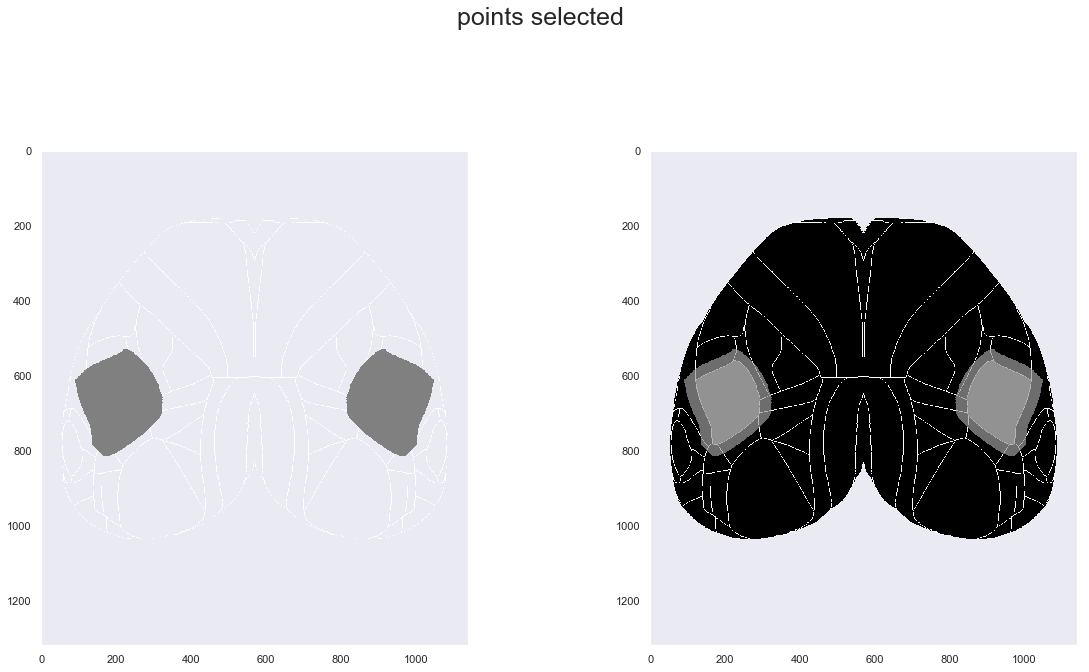

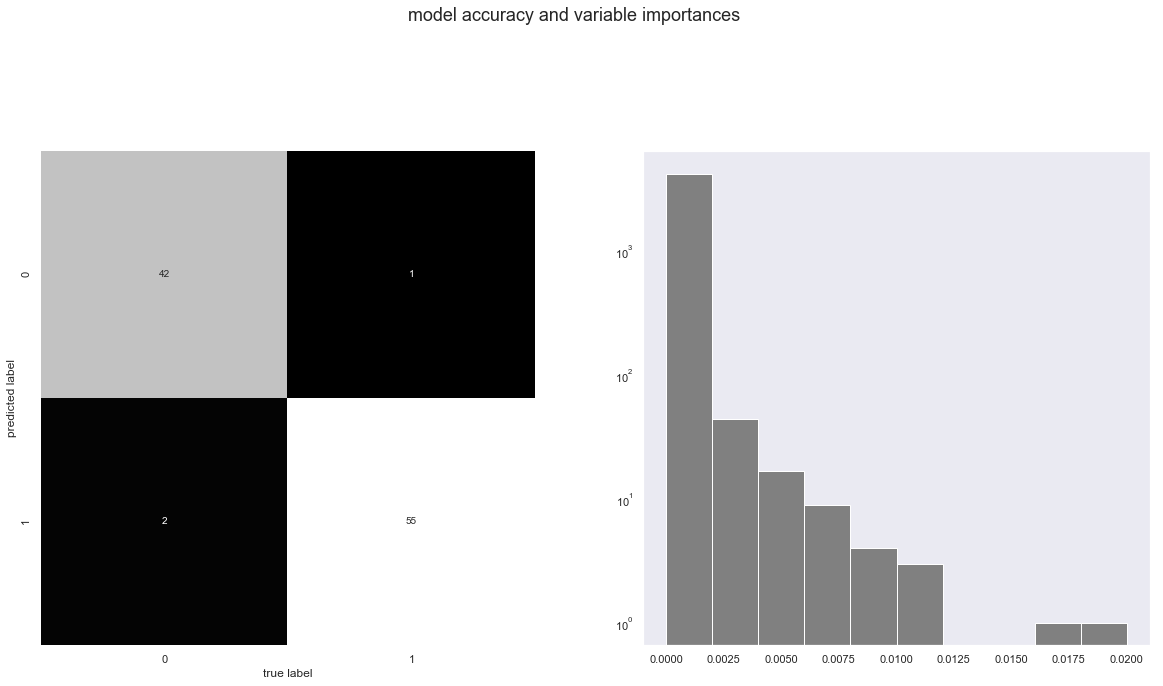

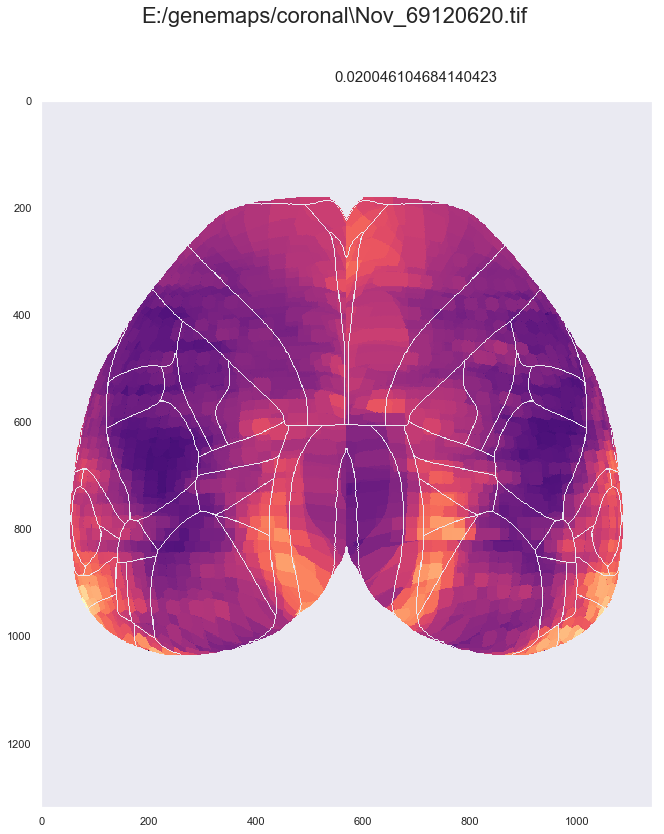

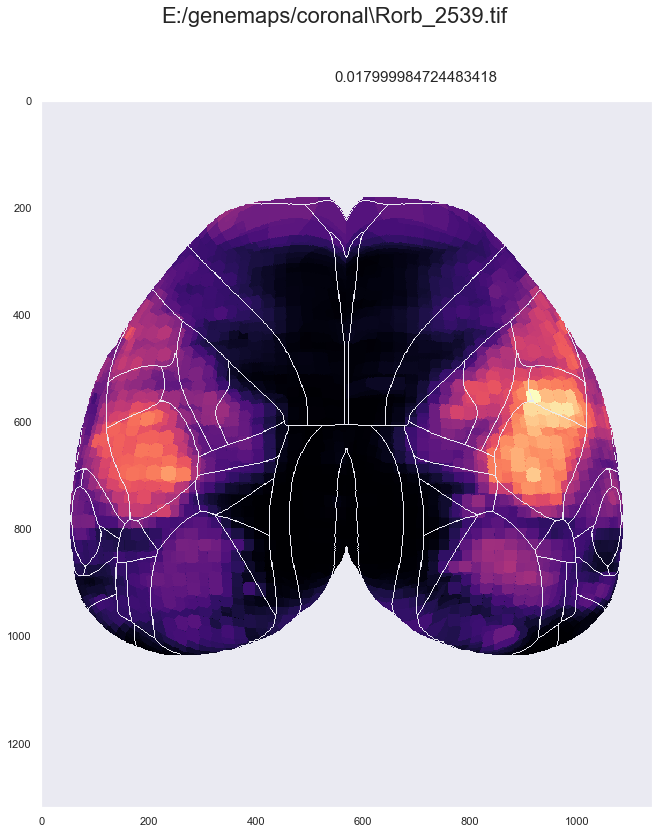

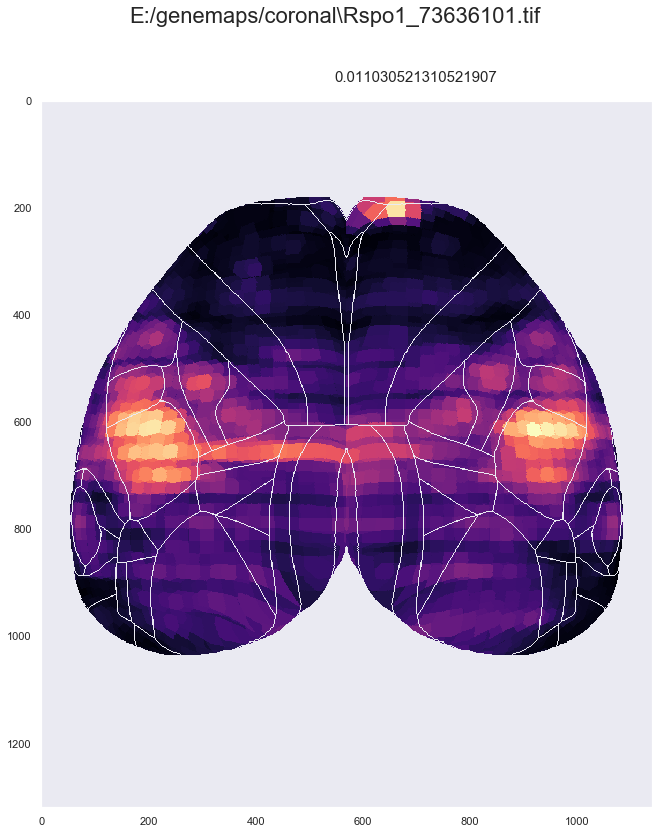

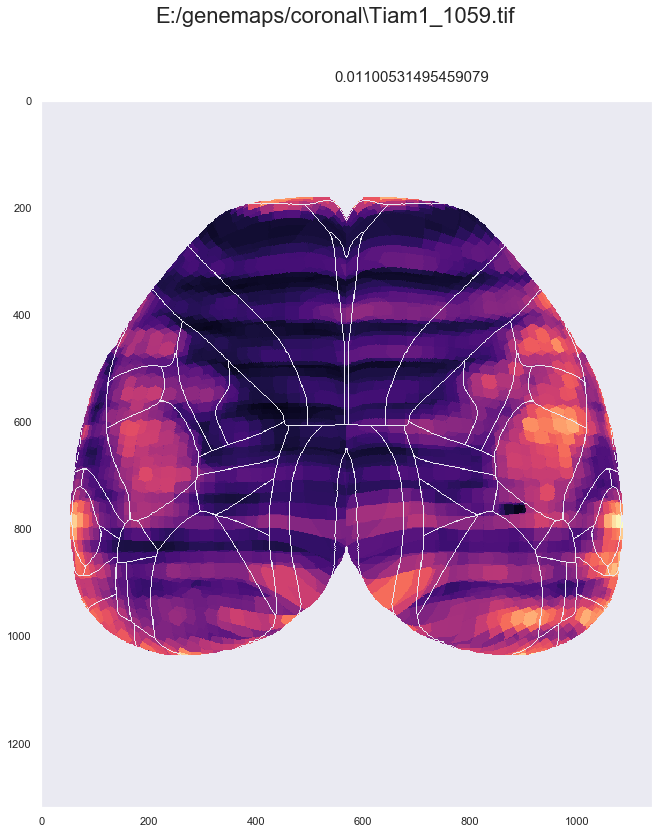

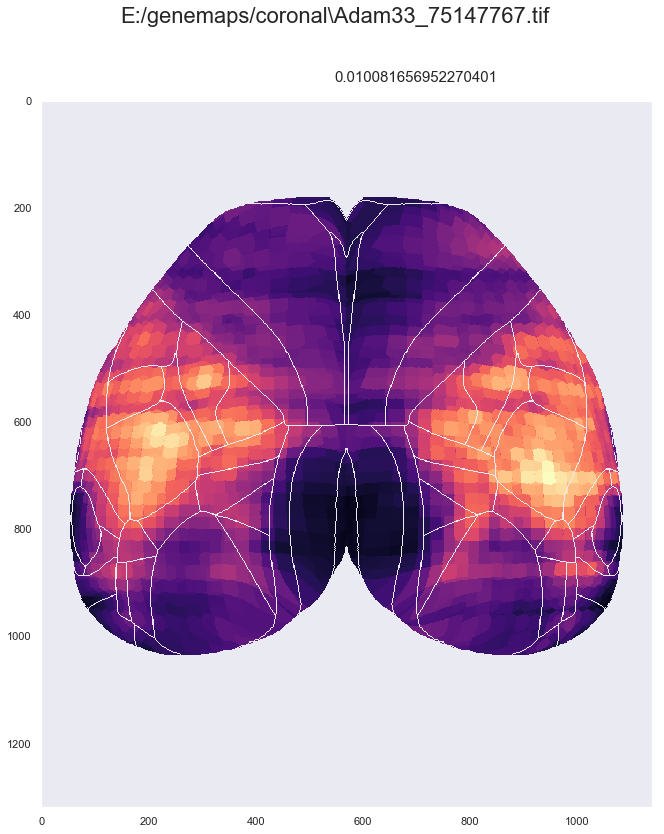

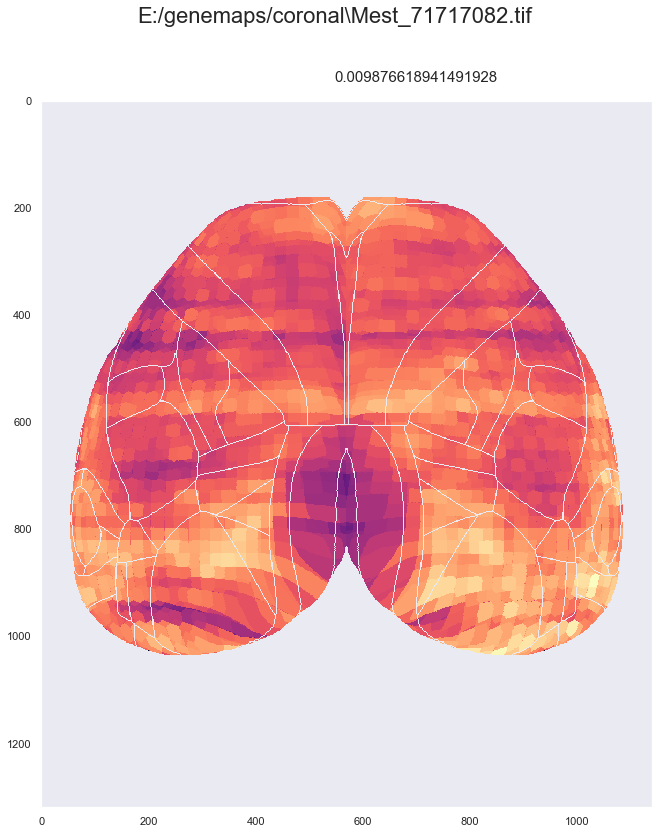

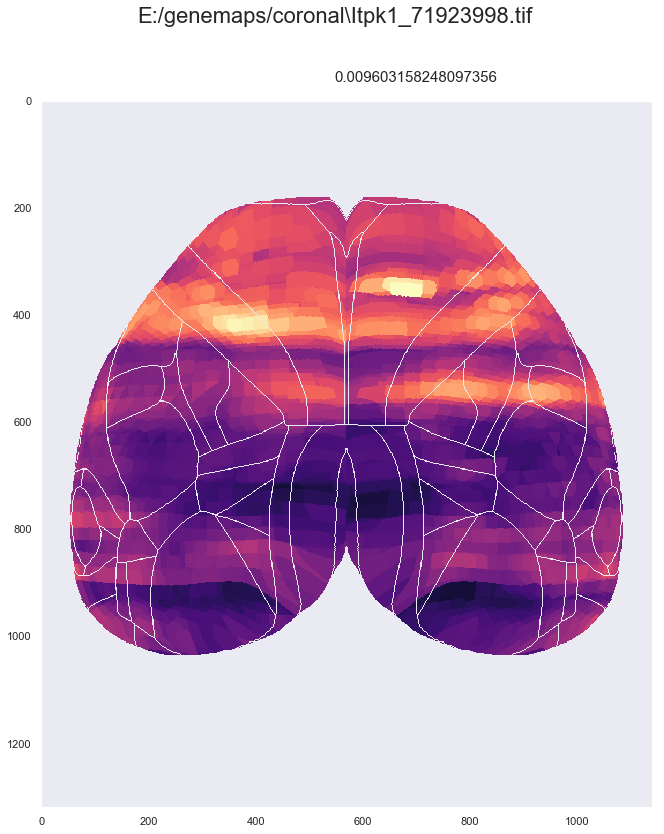

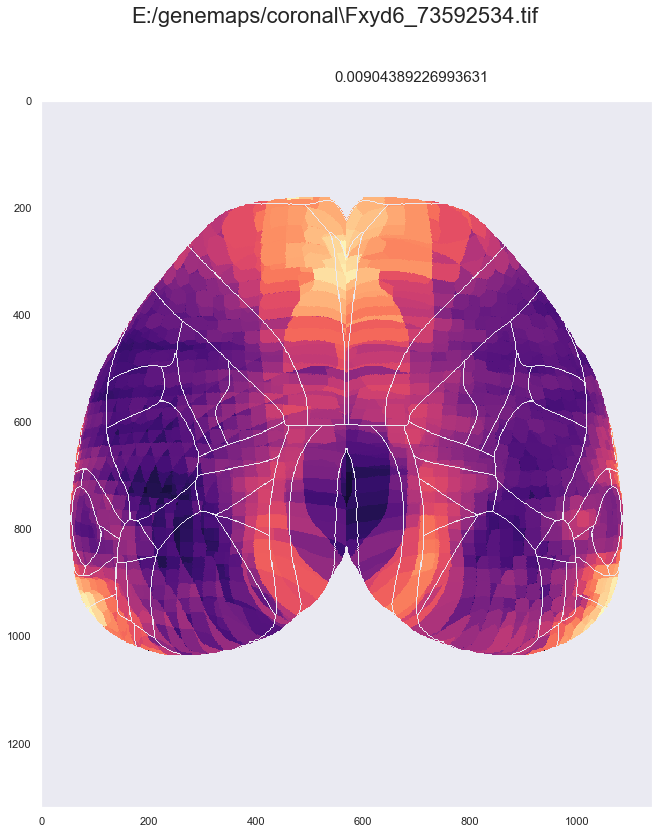

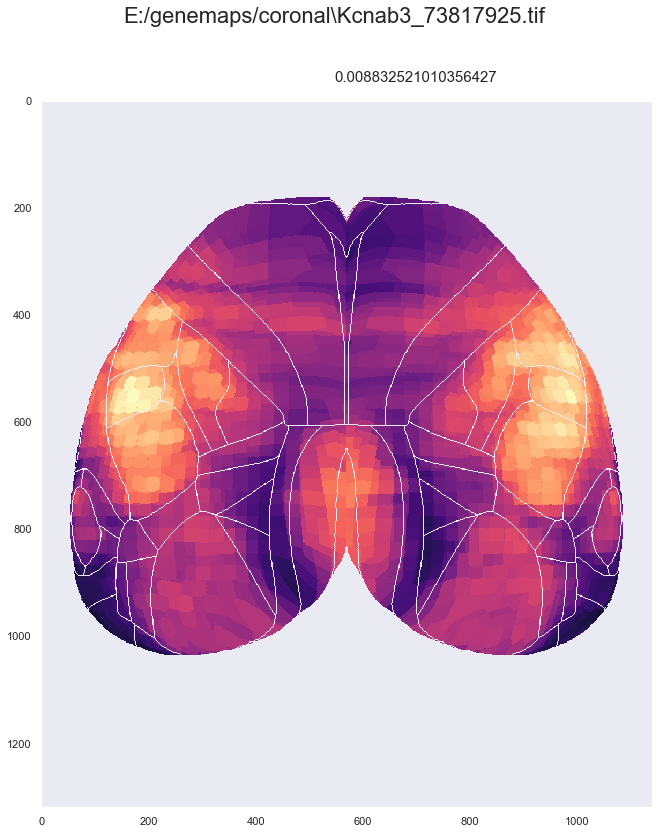

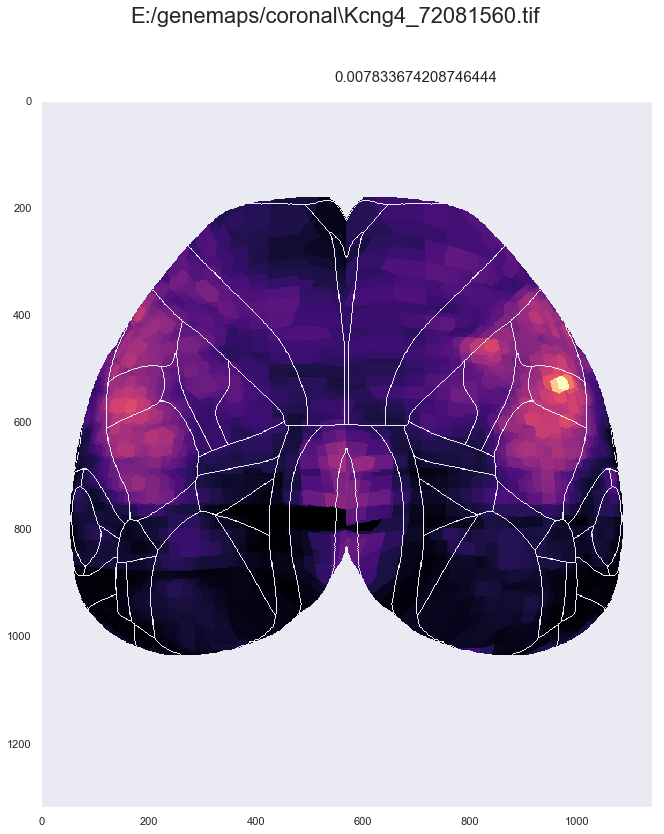

In [13]:
index = 329
name = "primary_somatosensory_barrel"
sortedvalues = main(index, name)